- get the graph
  - epochs per sample is included
  - initialize embedding

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from sklearn.datasets import make_moons

In [13]:
X_train, Y_train =  make_moons(1000, noise=0.1)
X_train_flat = X_train

In [14]:
X_test, Y_test = make_moons(1000, noise=0.1)
X_test_flat = X_test

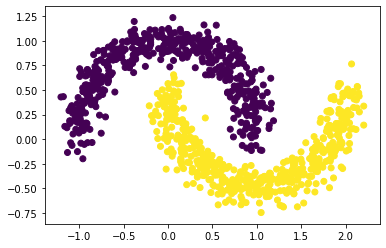

In [15]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)

### Create model and train

In [49]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    training_epochs=50,
    negative_sample_rate=5,
    min_dist=0,
)

In [50]:
from tfumap.umap import get_graph_elements

In [51]:
z = embedder.fit_transform(X_train)

tfUMAP(negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f74004e6dd8>,
       tensorboard_logdir='/tmp/tensorboard/20200706-134326',
       training_epochs=50)
Construct fuzzy simplicial set
Mon Jul  6 13:43:26 2020 Finding Nearest Neighbors
Mon Jul  6 13:43:26 2020 Finished Nearest Neighbor Search
Mon Jul  6 13:43:26 2020 Embedding with TensorFlow


Mon Jul  6 13:44:08 2020 Finished embedding


### Plot model output

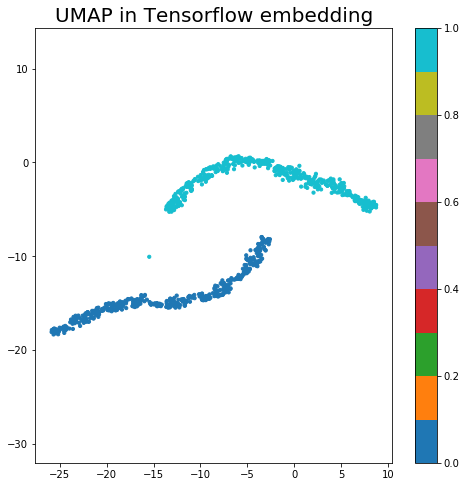

In [52]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [53]:
z_test = embedder.transform(X_test_flat)

W0706 13:44:10.285960 140140441990976 base_layer.py:1790] Layer flatten_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



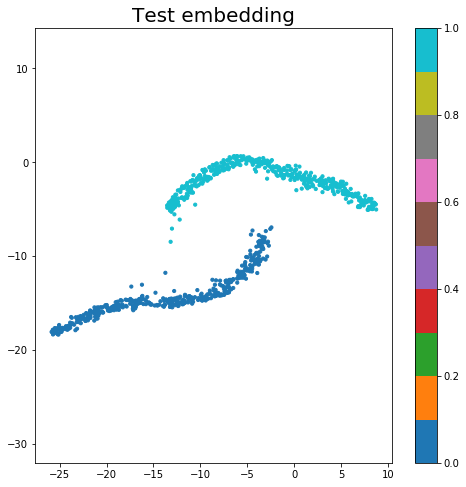

In [54]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [55]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [56]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594068e+09,1,3.012789,train,umap_loss
1,1.594068e+09,2,2.724626,train,umap_loss
2,1.594068e+09,3,2.500602,train,umap_loss


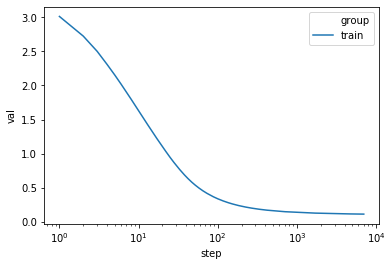

In [57]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Compare to direct embedding with base UMAP

In [58]:
from umap import UMAP

In [63]:
z_umap = UMAP(verbose=True, min_dist=0).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0, verbose=True)
Construct fuzzy simplicial set
Mon Jul  6 15:38:53 2020 Finding Nearest Neighbors
Mon Jul  6 15:38:53 2020 Finished Nearest Neighbor Search
Mon Jul  6 15:38:53 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jul  6 15:38:58 2020 Finished embedding


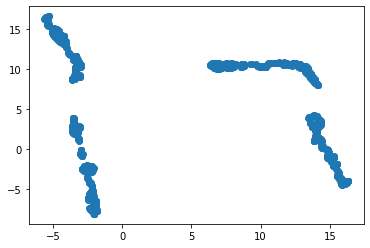

In [64]:
plt.scatter(z_umap[:,0], z_umap[:,1])

In [65]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.17477006931056294


Text(0.5, 1.0, 'UMAP with UMAP-learn')

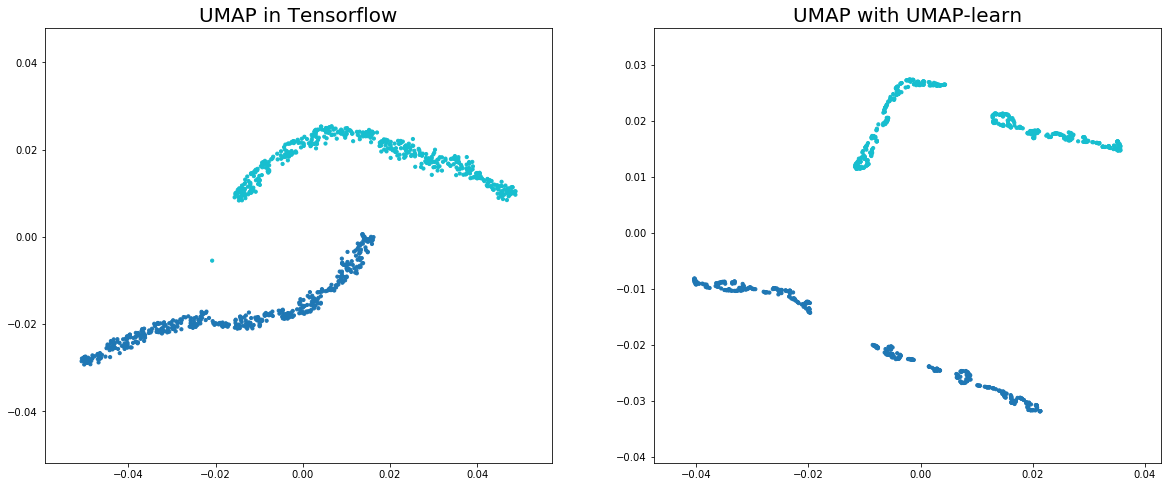

In [66]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);